In [41]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

HOST = "localhost"
PORT = 4223
SS1_UID = "6wVow5"
# SS2_UID = "6CQ4nA"
# LC1_UID = 'Khd'
LC2_UID = 'KiG'
import time

from tinkerforge.ip_connection import IPConnection
from tinkerforge.brick_silent_stepper import BrickSilentStepper
from tinkerforge.bricklet_load_cell_v2 import BrickletLoadCellV2
import numpy as np
from tqdm import tqdm
import pandas as pd
import time

# 10.4 initial distance, 2.8 mm thickness
# SAVE_FILENAME = "04.03.25_WT_idx0.csv"

# 7.8 initial distance, 2.8mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_WT_idx1_already_stressed.csv"


# 5.2 initial distance, 2.2mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_WT_idx2.csv"

# 5.2 initial distance, 4.5mm width, 0.4mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_BslA_idx0.csv"

# 5.1 initial distance, 4.5mm width, 0.4mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_BslA_idx1.csv"


# # 5.2 initial distance, 6mm width, 0.8mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_WT_idx3_pressed_dry.csv"


# 5.1 initial distance, 3.4mm width, 0.4mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_BslA_idx2.csv"


# 6.1 initial distance, 4.5mm width, 0.16mm thickness
# SAVE_FILENAME = "tensile_tests/04.06.25_WT_dry_idx0.csv"


# 5.3 initial distance, 2mm width, 0.5mm thickness, slipped...
# SAVE_FILENAME = "tensile_tests/04.06.25_WT_dry_idx1.csv"

# # 5.3 initial distance, 2mm width, 0.5mm thickness, retry!
# SAVE_FILENAME = "tensile_tests/04.06.25_WT_dry_idx2.csv"


# 5.6 initial distance, 4.5mm width, 0.25mm thickness
SAVE_FILENAME = "tensile_tests/04.06.25_BslA_dry_idx0.csv"


ipcon = IPConnection() # Create IP connection
ss1 = BrickSilentStepper(SS1_UID, ipcon) # Create device object
# ss2 = BrickSilentStepper(SS2_UID, ipcon) # Create device object
# lc1 = BrickletLoadCellV2(LC1_UID, ipcon) # Create device object
lc2 = BrickletLoadCellV2(LC2_UID, ipcon) # Create device object
ipcon.connect(HOST, PORT) # Connect to brickd

In [42]:
PITCH = 5  # millimeters / turn
GEAR_RATIO = 1  # Assuming no gear ratio? https://www.omc-stepperonline.com/download/11HS12-0956D.pdf
MICRO_STEPS_PER_REV, RESOLUTION_SETTING = (
    256,
    ss1.STEP_RESOLUTION_256,
)  # 256 micro-steps per macro-step
MACRO_STEPS_PER_REV = 200  # 200 macro-steps per revolution (1.8 degree step angle)
STEPS_PER_REV = GEAR_RATIO * MACRO_STEPS_PER_REV * MICRO_STEPS_PER_REV
FINAL_DISTANCE = 5  # mm
MEASURE_FREQ = 0.1  # mm per measurement


MAX_VELOCITY = 0.1  # mm / s
MAX_STEPS_PER_SECOND = (
    MAX_VELOCITY * STEPS_PER_REV
) / PITCH  # Velocity: steps / sec
FINAL_STEPS = (FINAL_DISTANCE * STEPS_PER_REV) / PITCH
# MEASURE_FREQ_IN_STEPS = (STEPS_PER_REV * MEASURE_FREQ) / PITCH



In [43]:
df = pd.DataFrame(columns = ['Time', 'Force (Newtons)', 'Distance (millimeters)'])

ss1.enable() 
ss1.set_current_position(0) # Initialize to 0
ss1.set_motor_current(800) # 800 mA
ss1.set_step_configuration(RESOLUTION_SETTING, True) # 1 / RESOLUTION_SETTING steps (interpolated)
ss1.set_max_velocity(MAX_STEPS_PER_SECOND) # Velocity: steps/s
ss1.set_speed_ramping(500, 5000) # Fast deacceleration (5000 steps/s^2) for stopping

# Initialize Tar & Set Stepper position to 0

# lc1_tar = np.mean([lc1.get_weight() for i in range(1000)])
lc2_tar = np.mean([lc2.get_weight() for i in range(1000)])

print(lc2_tar)

30255.973


In [44]:
STARTING_TIME = time.time_ns() // 1_000_000
total_steps, total_distance, total_time, total_newtons, idx = 0, 0, 0, 0, 0

INITIALIZATION_TIME = 5 # 60 seconds to measure creep...

for idx in range(INITIALIZATION_TIME * 100):
    lc2_weight = (lc2.get_weight()) - lc2_tar
    total_weight = lc2_weight / 10000
    total_newtons = -total_weight / 1000 * 9.80665
    total_time = (time.time_ns() // 1_000_000) - STARTING_TIME
    total_distance = total_steps / STEPS_PER_REV * PITCH
    new_row = pd.DataFrame(
        {
            "Time": [total_time],
            "Distance (millimeters)": [total_distance],
            "Force (Newtons)": [total_newtons],
        }
    )
    df = pd.concat([df, new_row], ignore_index=True)
    time.sleep(0.01)

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/2621264185.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [45]:
# LETS RUN IT! NOTE: slapping on the negative sign sets the stepper to stretch
ss1.set_steps(-FINAL_STEPS)

In [46]:
from IPython.display import clear_output

while total_distance < FINAL_DISTANCE:
    total_steps = -ss1.get_current_position()
    total_time = (time.time_ns() // 1_000_000) - STARTING_TIME
    total_distance = total_steps / STEPS_PER_REV * PITCH
    # lc1_weight = lc1_tar - lc1.get_weight()  # gramspp
    lc2_weight = (lc2.get_weight()) - lc2_tar
    # NOTE: Yitong calibrated the load cells to 10,000x
    # sensitivity.... (with a 50gram weight said it was 500000 grams)
    total_weight = lc2_weight / 10000 #(lc1_weight + lc2_weight) / (2 * 10000)
    # TODO: DOES THIS COME OUT IN GRAMS?
    total_newtons = -total_weight / 1000 * 9.80665  # m/s^2
    clear_output(wait=True)  # Clear the previous output

    display(
        f"time {total_time:.0f}, lc2_weight {lc2_weight:.1f}, Total Time {total_time:.1f}, Total Weight {total_weight:.5f}, Total Newtons {total_newtons:.5f}"
    )

    # display(f'{idx} Total Distance {total_distance:.5f}, Total Force {total_newtons:.5f}, Total Time {total_time:.5f}')

    # Create a new row as a DataFrame
    new_row = pd.DataFrame(
        {
            "Time": [total_time],
            "Distance (millimeters)": [total_distance],
            "Force (Newtons)": [total_newtons],
        }
    )

    # Use pd.concat to add the new row to the existing DataFrame
    df = pd.concat([df, new_row], ignore_index=True)

    time.sleep(0.01)
    # clear_output(wait=True)
    df.to_csv(SAVE_FILENAME)

'time 58588, lc2_weight -24665.0, Total Time 58588.0, Total Weight -2.46650, Total Newtons 0.02419'

In [47]:
time.sleep(2) # Wait for motor to actually stop
ss1.disable()
ipcon.disconnect()

In [48]:
df.to_csv(SAVE_FILENAME)
df

,Time,Force (Newtons),Distance (millimeters)
0,59,0.002536,0.000000
1,83,0.002415,0.000000
2,99,0.002415,0.000000
3,116,0.002310,0.000000
4,130,0.002310,0.000000
...,...,...,...
2469,58466,0.024200,4.996875
2470,58501,0.024200,4.998535
2471,58530,0.024200,4.999414
2472,58558,0.024188,4.999902


In [49]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# BslA-modified leather Young's Modulus Calculation

In [51]:
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt


def plot_force_distance(filename):
    df = pd.read_csv(filename)
    fig = px.line(
        df,
        x="Distance (millimeters)",
        y="Force (Newtons)",
        title=f"Force / Distance of {filename}",
    )
    fig.show()
    return df


def calculate_stress_strain(
    filename,
    df,
    width,
    thickness,
    total_length,
    init_distance,
    final_distance,
    filter_to_strain_range=(0, 0.5),
):
    cross_sectional_area = (width * thickness) / 10**6  # mm^2 turned into m^2
    filtered_df = df
    filtered_df["Strain (%)"] = (
        filtered_df["Distance (millimeters)"] - init_distance
    ) / total_length
    # Divide by 1e6 to convert to MPa
    filtered_df["Stress (MPa)"] = filtered_df["Force (Newtons)"] / (
        cross_sectional_area * 1e6
    )
    peak_force_row = filtered_df.loc[filtered_df["Force (Newtons)"].idxmax()]
    if filter_to_strain_range is not None:
        filtered_df = filtered_df[
            (filtered_df["Strain (%)"] >= filter_to_strain_range[0])
            & (filtered_df["Strain (%)"] <= filter_to_strain_range[1])
        ]
    print("Peak Force Row:", peak_force_row)
    fig = px.line(
        filtered_df,
        x="Strain (%)",
        y="Stress (MPa)",
        title=f"Stress / Strain of {filename}",
    )
    fig.show()
    return filtered_df


def calculate_youngs_modulus(filtered_df, final_strain, final_stress):
    init_strain, init_stress = 0, 0
    filtered_df["Delta Strain (%)"] = filtered_df["Strain (%)"].diff()
    # Use the trapezoidal rule to calculate the area under the curve
    # for "toughness" in terms of energy per unit area (Joules per square meter, for instance)

    print(f"Failure Strain {final_strain:.4f} Peak Stress (MPa) {final_stress:.4f}")
    youngs_modulus = (final_stress - init_stress) / (final_strain - init_strain)
    print(f"Young's Modulus {youngs_modulus:.4f} MPa")
    filtered_df["Trapezoid Area (J/m^3)"] = (
        0.5
        * (filtered_df["Stress (MPa)"] + filtered_df["Stress (MPa)"].shift(1))
        * filtered_df["Delta Strain (%)"]
    )
    filtered_df["Trapezoid Area (J/m^3)"].fillna(0, inplace=True)
    total_toughness = filtered_df["Trapezoid Area (J/m^3)"].sum()
    print(f"Total Toughness: {total_toughness:.6f} J/m^3")

In [52]:
wt_dry_filename = "tensile_tests/04.06.25_WT_dry_idx0.csv"
wt_dry_df = plot_force_distance(wt_dry_filename)

In [53]:
# 6.1 initial distance, 4.5mm width, 0.16mm thickness
wt_dry_filtered_df = calculate_stress_strain(
    filename=wt_dry_filename,
    df=wt_dry_df,
    width=4.5,
    thickness=0.16,
    total_length=6.1,
    init_distance=0.0,
    final_distance=1.757,
)

Peak Force Row: Unnamed: 0                 1311.000000
Time                      25559.000000
Force (Newtons)               3.737339
Distance (millimeters)        1.749219
Strain (%)                    0.286757
Stress (MPa)                  5.190749
Name: 1311, dtype: float64


In [54]:
calculate_youngs_modulus(wt_dry_filtered_df, final_strain=0.28808, final_stress=5.190)

Failure Strain 0.2881 Peak Stress (MPa) 5.1900
Young's Modulus 18.0158 MPa
Total Toughness: 0.767455 J/m^3


/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:69: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi

In [55]:
# 5.1 initial distance, 4.5mm width, 0.4mm thickness
blsa_filename = "tensile_tests/04.03.25_BslA.csv"
blsa_df = plot_force_distance(blsa_filename)

In [56]:
blsa_filtered_df = calculate_stress_strain(
    filename=blsa_filename,
    df=blsa_df,
    width=4.5,
    thickness=0.4,
    total_length=5.1,
    init_distance=0,
    final_distance=1.174,
)


Peak Force Row: Unnamed: 0                 1056.000000
Time                      20201.000000
Force (Newtons)               6.842268
Distance (millimeters)        1.169629
Strain (%)                    0.229339
Stress (MPa)                  3.801260
Name: 1056, dtype: float64


In [57]:
calculate_youngs_modulus(blsa_filtered_df, final_strain=0.23257, final_stress=3.794)

Failure Strain 0.2326 Peak Stress (MPa) 3.7940
Young's Modulus 16.3134 MPa
Total Toughness: 0.607112 J/m^3


/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:69: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi

# Wildtype Young's Modulus Calculation


In [58]:
wt_filename = "tensile_tests/04.03.25_WT.csv"
wt_df = plot_force_distance(wt_filename)

In [59]:
# 5.2 initial distance, 6mm width, 0.8mm thickness
wt_filtered_df = calculate_stress_strain(
    filename=wt_filename,
    df=wt_df,
    width=6,
    thickness=0.8,
    total_length=5.2,
    init_distance=0.207,
    final_distance=2.033594,
)

Peak Force Row: Unnamed: 0                 1392.000000
Time                      28403.000000
Force (Newtons)              10.464828
Distance (millimeters)        1.987598
Strain (%)                    0.342423
Stress (MPa)                  2.180172
Name: 1392, dtype: float64


In [60]:
calculate_youngs_modulus(wt_filtered_df, final_strain=0.351268, final_stress=2.177)

Failure Strain 0.3513 Peak Stress (MPa) 2.1770
Young's Modulus 6.1975 MPa
Total Toughness: 0.476844 J/m^3


/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_24667/155169248.py:69: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi

# Graphing them together

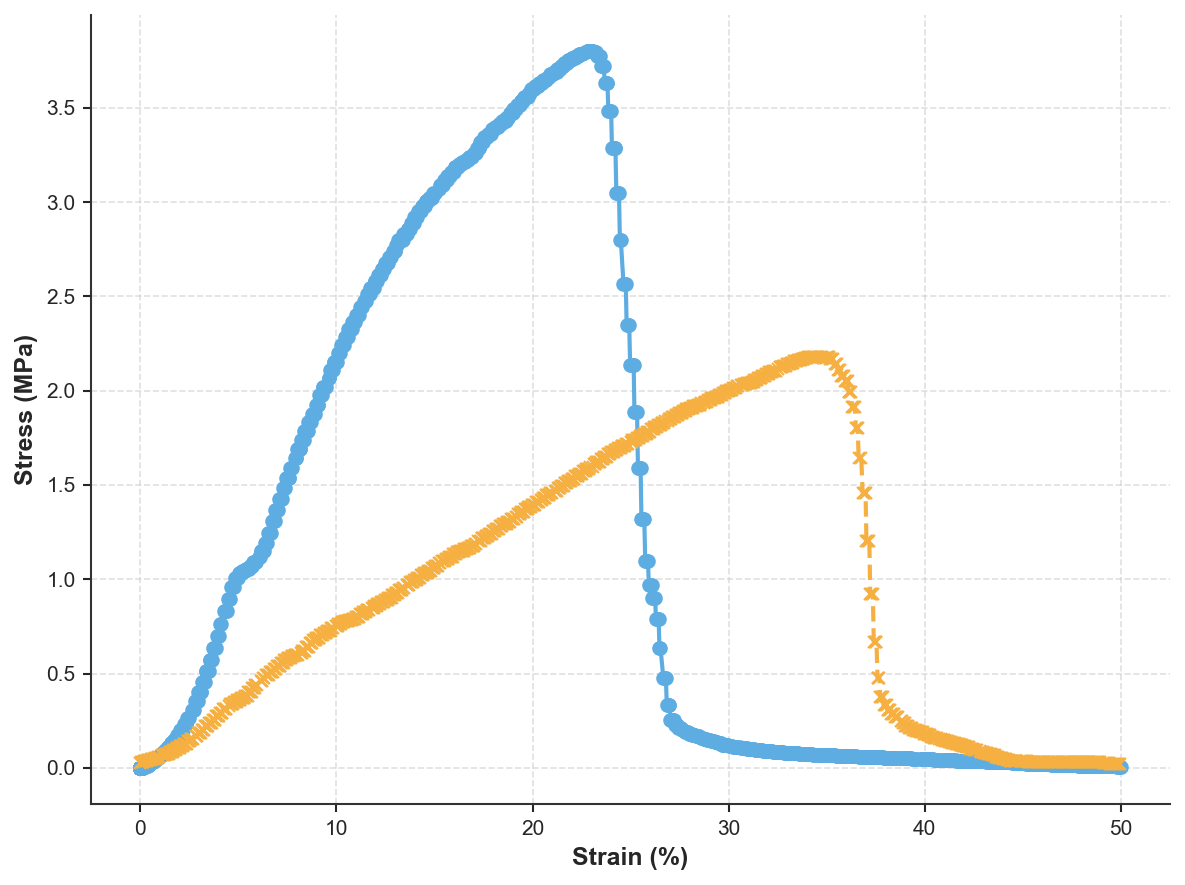

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib as mpl

# Global plot style
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linestyle'] = '--'

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# Plotting the first dataframe
ax.plot(100 * blsa_filtered_df['Strain (%)'], blsa_filtered_df['Stress (MPa)'],
        label='NaOH Treated BslA-Activated', color='#5DADE2', linewidth=2, linestyle='-', marker='o')

#         light_blue = '#5DADE2'
# light_orange = '#F5B041'


# Plotting the second dataframe
ax.plot(100 * wt_filtered_df['Strain (%)'], wt_filtered_df['Stress (MPa)'],
        label='Untreated Wild Type', color='#F5B041', linewidth=2, linestyle='--', marker='x')

# Axis labels
ax.set_xlabel('Strain (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stress (MPa)', fontsize=12, fontweight='bold')

# Title (optional)
# ax.set_title('Stress vs. Strain for BslA and WT Materials', fontsize=14, fontweight='bold', pad=15)

# Ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=4)
ax.grid(True, linestyle='--', alpha=0.6)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
# ax.legend(fontsize=12, frameon=False)

# Final layout adjustments
plt.tight_layout()

# Optional save
# plt.savefig("stress_strain_comparison_styled.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


# Second experiment

In [ ]:
filename = "tensile_tests/04.03.25_WT_idx1_already_stressed.csv"
df = plot_force_distance(filename)

In [ ]:
# 7.8 initial distance, 2.8mm thickness
# SAVE_FILENAME = "tensile_tests/04.03.25_WT_idx1_already_stressed.csv"
# 5.2 initial distance, 6mm width, 0.8mm thickness
filtered_df = calculate_stress_strain(
    filename=filename,
    df=df,
    width=5,
    thickness=2.8,
    total_length=7.8,
    init_distance=0.0,
    final_distance=1.95,
)

Peak Force Row: Unnamed: 0                 1353.000000
Time                      27828.000000
Force (Newtons)               9.325871
Distance (millimeters)        1.954297
Strain (%)                    0.250551
Stress (MPa)                  0.666134
Name: 1353, dtype: float64


In [ ]:
calculate_youngs_modulus(filtered_df, final_strain=0.25, final_stress=0.666)

Failure Strain 0.2500 Peak Stress (MPa) 0.6660
Young's Modulus 2.6640 MPa
Total Toughness: 0.111815 J/m^3


/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_26403/155169248.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_26403/155169248.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_26403/155169248.py:69: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. Thi